# MEV-CBE Power Roll Up Example

Link to the example in the Cookbook:\
[https://mms.openmbee.org/alfresco/mmsapp/mms.html#/projects/PROJECT-ID_2[...]8/views/_19_0_2_8b50284_1582591660624_573606_56409](https://mms.openmbee.org/alfresco/mmsapp/mms.html#/projects/PROJECT-ID_2_2_17_7_33_25_AM_3ccfaf88_159fe0d7ba9__7d4e_cae_tw_jpl_nasa_gov_127_0_0_1/master/documents/_18_0_6_88f0277_1497548395207_75642_302748/views/_19_0_2_8b50284_1582591660624_573606_56409)


## Structure & Behavior
![img/MEV_structure.svg](img/MEV_structure.svg)
![img/Comp1.jpg](img/Comp1.jpg)
## Analysis
![img/MEV_analysis.svg](img/MEV_analysis.svg)
## Constraint
![img/MEV_constraint.svg](img/MEV_constraint.svg)


In [3]:
package 'MEVCBEPowerRollUp'{
    import ScalarValues::Real;
    import ScalarFunctions::sum;
    import 'PowerRollUpPatternPkg'::*;
    import Structure::*;
    
    value type Power specializes Real;
    
    package 'PowerRollUpPatternPkg' {
        
        constraint def total(child : Real[0..*], total : Real, parent : Real){
            total = sum(child) + parent;
        }
        
        block 'PowerRollUpPattern'{
            part subPower : 'PowerRollUpPattern'[*];
            value power : Power;
            value totalPower : Power;
            
            constraint sum : total(child = subPower::totalPower, 
                                   total = totalPower, 
                                   parent = power);
            }
        /* alternative to constraint approach
        block PowerRollUpPattern{
            part subPower : PowerRollUpPatter[*];
            value power : Power;
            value totalPower : Power = sum(subPower::totalPower) + power;
        }
        */
    }
    
    package 'Structure' {
        import PowerRollUpPatternPkg::*;
        value type E1;
        value type E2;
        
        block Component specializes PowerRollUpPattern{
            /* This exists since component1/component2 share the same behavior,
            in original model they each have their own identical behavior.
            To recreate that, duplicate this structure in both components
            */
            
            value s1Power : Power;
            value s2Power : Power;
                        
            state def ComponentBehavior;
            
            state componentBehavior : ComponentBehavior(
                s1Power : Power,
                s2Power : Power,
                PowerRollUpPower : Power) {
                
                entry; //then S1;
           
                state S1{
                    PowerRollUpPower = s1Power; 
                }
                transition S1_to_S2
                    first S1
                    accept E1 
                    then S2;
                
                state S2{
                    PowerRollUpPower = s2Power; 
                }
                
                transition S2_to_S1
                    first S2
                    accept E2 
                    then S1;
            }
        }
        
        block Car specializes PowerRollUpPattern{
            part comp1 : Comp1{
                exhibit componentBehavior(
                    s1Power = Comp1::s1Power,
                    s2Power = Comp1::s2Power,
                    PowerRollUpPower = Comp1::power
                );
            }
            part comp2 : Comp2{
                exhibit componentBehavior(
                    s1Power = Comp2::s1Power,
                    s2Power = Comp2::s2Power,
                    PowerRollUpPower = Comp2::power
                );
            }
        }
        
        block Comp1 specializes Component{
            :>> s1Power = 1;
            :>> s2Power = 2;
        }
        
        block Comp2 specializes Component{
            :>> s1Power = 3;
            :>> s2Power = 4;
        }
    }
    
    package Configurations {
        // how to specify different configs?
    }
    
    package 'Analysis' {
        block 'CarCBE' specializes Car, PowerRollUpPattern{
            
            part redefines comp1 subsets subPower {
                value redefines s1Power = 1.0;
                value redefines s2Power = 2.0;
            }
            part redefines comp2 subsets subPower {
                value redefines s1Power = 7.0;
                value redefines s2Power = 4.0;
            }
        }
        
        block 'CarMEV' specializes Car, PowerRollUpPattern{

            part redefines comp1 subsets subPower {
                value redefines s1Power = 1.0;
                value redefines s2Power = 2.0;
            }
            part redefines comp2 subsets subPower {
                value redefines s1Power = 3.0;
                value redefines s2Power = 4.0;
            }
        }
 
        block Analysis {
            value e1 : E1;
            value e2 : E2;
            part carCBE : 'CarCBE';
            part carMEV : 'CarMEV';
            
            //using constraints (similar to methods in sysml v1)
            value margin : Power;
            
            constraint difference : Difference(
                a = carMEV::totalPower,
                b = carCBE::totalPower,
                diff = margin);
            
            constraint def Difference(a : Power, b : Power, diff : Power){
                diff = a - b;
            }
            
            action analysisSignals{
                send e1 to carCBE::comp1;
                send e1 to carCBE::comp2;
                send e1 to carMEV::comp1;
                send e1 to carMEV::comp2;
            }
            
            // or using analysis cases
            
            analysis def RollUpScenario (car : Car) totalPowerUsed : Power {
                objective{
                    /* take in a given car configuration (CBE, MEV, etc)
                    perform a set of actions and return total power used
                    */
                }

                action scenario{
                    send e1 to car::comp1;
                    send e1 to car::comp2; 
                } //could specify configurations/options with different analysis cases

                car::totalPower
            }
            
            value carCBEValue : Power = RollUpScenario (carCBE);
            value carMEVValue : Power = RollUpScenario (carMEV);
            value margin : Power = carMEVValue - carCBEValue;
            
        }
        
    } //END analysis package
    
}


Package MEVCBEPowerRollUp (e603b94c-88e4-41ac-a3b6-9316fb29aab3)


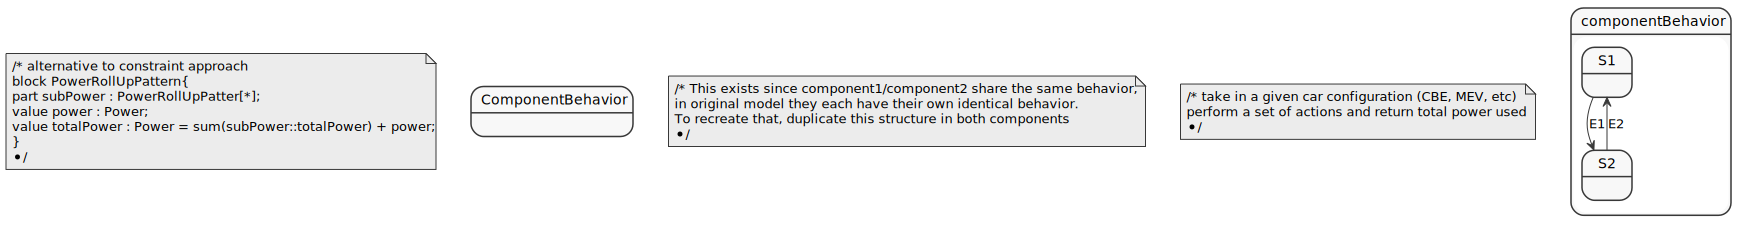

In [5]:
%viz --view=StateMachine MEVCBEPowerRollUp